In [1]:
from pyomo.environ import *
import pandas as pd
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [2]:
model = AbstractModel()

# Sets
model.t = RangeSet(1,24)
model.g = RangeSet(1,4)

# Parameters
model.PW = pd.read_excel("Salehi.xlsx", sheet_name="PW", header=0, index_col=0, usecols="A:Y", nrows=4)
model.PW_bounds = pd.read_excel("Salehi.xlsx", sheet_name="PW_bounds", header=0, index_col=0, usecols="A:Y", nrows=4)

model.PS = pd.read_excel("Salehi.xlsx", sheet_name="PS", header=0, index_col=0, usecols="A:Y", nrows=4)
model.PS_bounds = pd.read_excel("Salehi.xlsx", sheet_name="PS_bounds", header=0, index_col=0, usecols="A:Y", nrows=4)

model.PB = pd.read_excel("Salehi.xlsx", sheet_name="PB", header=0, index_col=0, usecols="A:Y", nrows=4)
model.PB_bounds = pd.read_excel("Salehi.xlsx", sheet_name="PB_bounds", header=0, index_col=0, usecols="A:Y", nrows=4)

model.PB_charge_wind = pd.read_excel("Salehi.xlsx", sheet_name="PB_charge_wind", header=0, index_col=0, usecols="A:Y", nrows=4)
model.PB_charge_solar = pd.read_excel("Salehi.xlsx", sheet_name="PB_charge_solar", header=0, index_col=0, usecols="A:Y", nrows=4)

model.Demand = pd.read_excel("Salehi.xlsx", sheet_name="Demand", header=0, index_col=0, usecols="A:B", nrows=24)

model.eta_c = 0.95
model.eta_dc = 0.9

# Variables
def W_rule(model, g,t):
    return (0,model.PW_bounds.loc[g,t])
model.W = Var(model.g, model.t, domain=NonNegativeReals, bounds=W_rule)

def S_rule(model, g,t):
    return (0,model.PS_bounds.loc[g,t])
model.S = Var(model.g, model.t, domain=NonNegativeReals, bounds=S_rule)

def B_rule(model, g,t):
    return (0,10)
#model.PB_bounds.loc[g,t]
model.B = Var(model.g, model.t, domain=NonNegativeReals, bounds=B_rule)

model.Ich = Var(model.g, model.t, domain=Binary)

model.Idch = Var(model.g, model.t, domain=Binary)

model.Pc = Var(model.g, model.t, domain=NonNegativeReals)

model.Pdc = Var(model.g, model.t, domain=NonNegativeReals)


model.B_charge_wind = Var(model.g, model.t, domain=NonNegativeReals)  # Amount of battery charge from wind
model.B_charge_solar = Var(model.g, model.t, domain=NonNegativeReals)  # Amount of battery charge from solar


# Constraints
def Balance_rule(model, t):
    return model.Demand.loc[t,'Demand'] <= sum(model.W[g,t] + model.S[g,t] + model.Pdc[g,t] - model.Pc[g,t] for g in model.g)
model.Balance = Constraint(model.t, rule=Balance_rule)

def SOC_rule(model, g,t):
    if t == 1:
        return model.B[g,t] == 5
    else:
         return model.B[g,t] == model.B[g,t-1] + ((model.Pc[g,t-1]*model.eta_c) - (model.Pdc[g,t-1]/model.eta_dc))
model.SOC = Constraint(model.g, model.t, rule=SOC_rule)

def CorDc_rule(model, g,t):
    return model.Ich[g,t] + model.Idch[g,t] <= 1
model.Cdc = Constraint(model.g, model.t, rule=CorDc_rule)

def Pcmax_rule(model, g,t):
    return model.Pc[g,t] <= model.Ich[g,t]*0.5*model.PB_bounds.loc[g,t]
model.Pcmax = Constraint(model.g, model.t, rule=Pcmax_rule)

def Pcmin_rule(model, g,t):
    return model.Pc[g,t] >= model.Ich[g,t]*0
model.Pcmin = Constraint(model.g, model.t, rule=Pcmin_rule)

def Pdcmax_rule(model, g,t):
    return model.Pdc[g,t] <= model.Idch[g,t]*0.5*model.PB_bounds.loc[g,t]
model.Pdcmax = Constraint(model.g, model.t, rule=Pdcmax_rule)

def Pdcmin_rule(model, g,t):
    return model.Pdc[g,t] >= model.Idch[g,t]*0
model.Pdcmin = Constraint(model.g, model.t, rule=Pdcmin_rule)

def Pcharge_rule(model, g,t):
    return model.charging_wind[g,t] + model.charging_solar[g,t] == model.Pc[g,t]
model.Pcharge = Constraint(model.g, model.t, rule=CorDc_rule)

def Pcharge_limit_rule(model, g,t):
    return model.Pc[g,t] <= model.S[g, t] + model.W[g, t]
model.Pcharge_limit = Constraint(model.g, model.t, rule=CorDc_rule)

def Charging_wind_rule(model, g, t):
    # Limit the charging of the battery using wind based on wind generation
    return model.B_charge_wind[g, t] <= model.W[g, t]
model.Charging_wind = Constraint(model.g, model.t, rule=Charging_wind_rule)

def Charging_solar_rule(model, g, t):
    # Limit the charging of the battery using solar based on solar generation
    return model.B_charge_solar[g, t] <= model.S[g, t]
model.Charging_solar = Constraint(model.g, model.t, rule=Charging_solar_rule)


# Objective Function
def OF_rule(model):
    return sum(
        model.PW.loc[g, t] * model.W[g, t] + 
        model.PS.loc[g, t] * model.S[g, t] + 
        model.PB.loc[g, t] * model.Pdc[g,t] - 
        model.PB_charge_wind.loc[g, t] * model.B_charge_wind[g, t] - 
        model.PB_charge_solar.loc[g, t] * model.B_charge_solar[g, t] 
        for g in model.g for t in model.t
    )
model.Obj = Objective(rule=OF_rule, sense=minimize)





In [3]:
Solver = SolverFactory('glpk')

instance = model.create_instance()
Results = Solver.solve(instance)
print('Objective Function =',instance.Obj())


Objective Function = 57362.561842105206


<ipython-input-4-2e52d7684bf4>:13: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[i].set_xticks(X,XL);


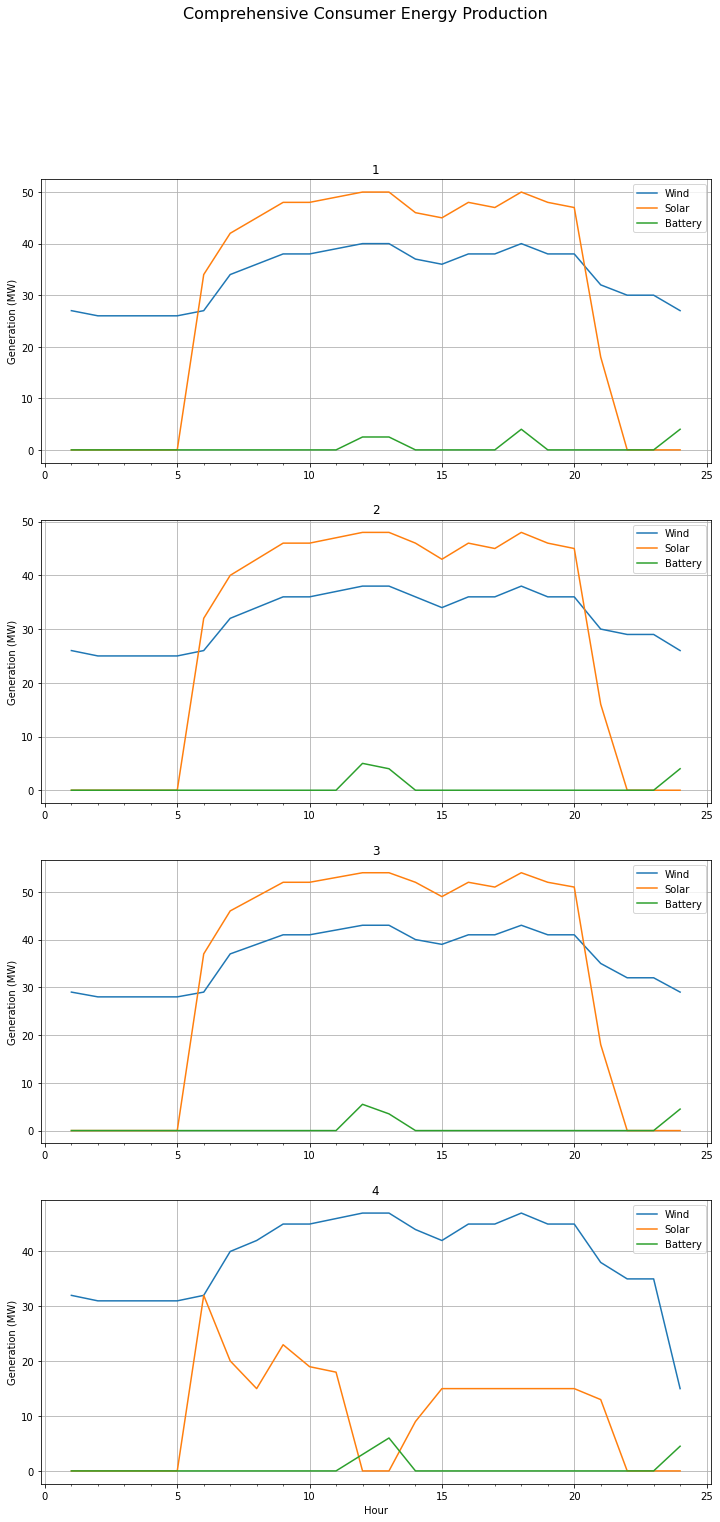

In [4]:
fig, axs = plt.subplots(4,1,figsize=(12,24))
for i in range(0,4):
    X = [t for t in instance.t]
    YW = [instance.W[i+1,t]() for t in instance.t]
    YS = [instance.S[i+1,t]() for t in instance.t]
    YB = [instance.Pdc[i+1,t]() for t in instance.t]
    axs[i].plot(X, YW, label=str("Wind"))
    axs[i].title.set_text(str(i+1))
    axs[i].plot(X, YS, label=str("Solar"))
    axs[i].plot(X, YB, label=str("Battery"))
    axs[i].legend();
    XL = [str(t) for t in instance.t]
    axs[i].set_xticks(X,XL);
    plt.xlabel('Hour');
    axs[i].set_ylabel('Generation (MW)');
    axs[i].grid();
    plt.suptitle("Comprehensive Consumer Energy Production", fontsize=16)


    

Text(0.5, 1.0, 'Wind Energy Production Overview')

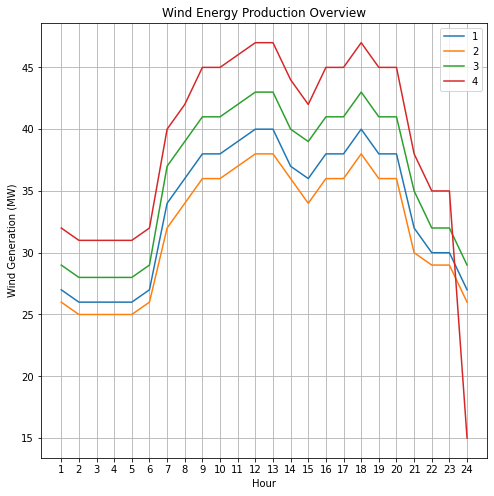

In [5]:
plt.figure(figsize=(8,8))
for g in instance.g:
    X = [t for t in instance.t]
    YW = [instance.W[g,t]() for t in instance.t]
    plt.plot(X, YW, label=str(g))
plt.legend();
XL = [str(t) for t in instance.t]
plt.xticks(X,XL);
plt.xlabel('Hour');
plt.ylabel('Wind Generation (MW)');
plt.grid()
plt.title("Wind Energy Production Overview")

Text(0.5, 1.0, 'Solar Energy Production Overview')

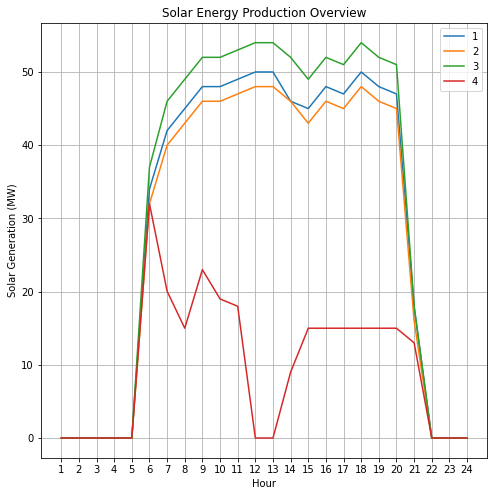

In [6]:
plt.figure(figsize=(8,8))
for g in instance.g:
    X = [t for t in instance.t]
    YS = [instance.S[g,t]() for t in instance.t]
    plt.plot(X, YS, label=str(g))
plt.legend();
XL = [str(t) for t in instance.t]
plt.xticks(X,XL);
plt.xlabel('Hour');
plt.ylabel('Solar Generation (MW)');
plt.grid()
plt.title("Solar Energy Production Overview")

Text(0.5, 1.0, 'Battery State of Charge (SoC)')

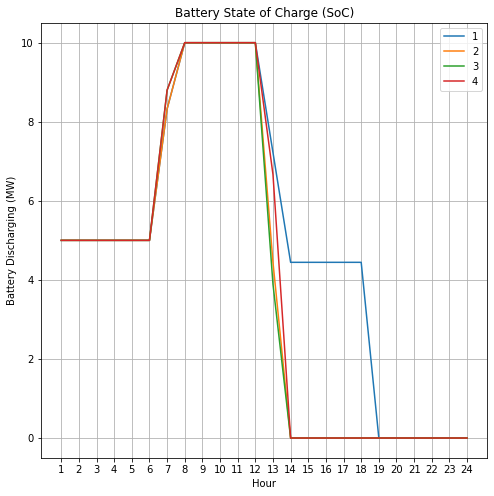

In [11]:
plt.figure(figsize=(8,8))
for g in instance.g:
    X = [t for t in instance.t]
    YB = [instance.B[g,t]() for t in instance.t]
    plt.plot(X, YB, label=str(g))
plt.legend();
XL = [str(t) for t in instance.t]
plt.xticks(X,XL);
plt.xlabel('Hour');
plt.ylabel('Battery Discharging (MW)');
plt.grid()
plt.title("Battery State of Charge (SoC)")


Text(0.5, 1.0, 'Battery Charging Patterns')

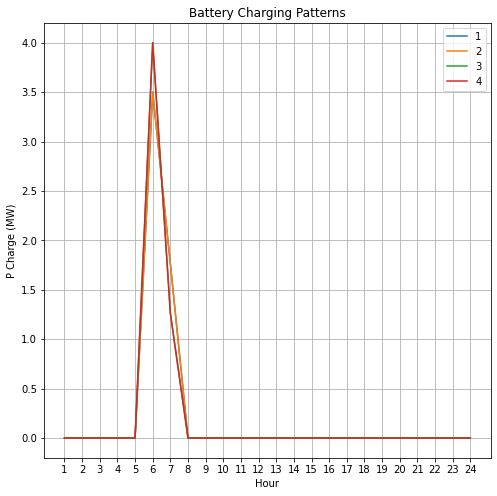

In [8]:
plt.figure(figsize=(8,8))
for g in instance.g:
    X = [t for t in instance.t]
    YPc = [instance.Pc[g,t]() for t in instance.t]
    plt.plot(X, YPc, label=str(g))
plt.legend();
XL = [str(t) for t in instance.t]
plt.xticks(X,XL);
plt.xlabel('Hour');
plt.ylabel('P Charge (MW)');
plt.grid()
plt.title("Battery Charging Patterns")

Text(0.5, 1.0, 'Battery Discharge Patterns')

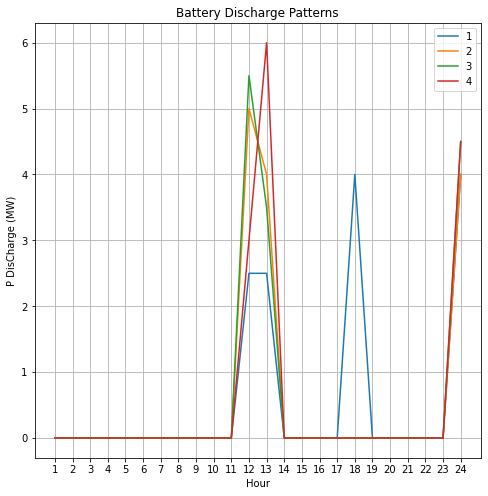

In [9]:
plt.figure(figsize=(8,8))
for g in instance.g:
    X = [t for t in instance.t]
    YPdc = [instance.Pdc[g,t]() for t in instance.t]
    plt.plot(X, YPdc, label=str(g))
plt.legend();
XL = [str(t) for t in instance.t]
plt.xticks(X,XL);
plt.xlabel('Hour');
plt.ylabel('P DisCharge (MW)');
plt.grid()
plt.title("Battery Discharge Patterns")

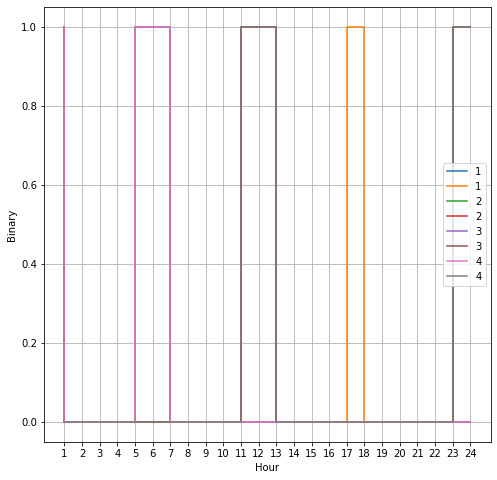

In [10]:
plt.figure(figsize=(8,8))
for g in instance.g:
    X = [t for t in instance.t]
    YIch = [instance.Ich[g,t]() for t in instance.t]
    YIdch = [instance.Idch[g,t]() for t in instance.t]
    plt.step(X, YIch, label=str(g))
    plt.step(X, YIdch, label=str(g))
plt.legend();
XL = [str(t) for t in instance.t]
plt.xticks(X,XL);
plt.xlabel('Hour');
plt.ylabel('Binary');
plt.grid()